In [33]:
#import jax.numpy as np
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
import numpy as np
#plt.rcParams["figure.figsize"] = (25,25)
from jax.config import config
config.update("jax_enable_x64", True)
import networkx as nx
from scipy.optimize import minimize
import jax.numpy as nnp
from jax import grad
import random

import laplacians as lp
import opt_helpers as oh


data

In [34]:
#numbers of edges connecting part and graph
n_con=0

#full graph including the part
full_graph='data/can_processed_'+str(n_con)+'.txt'
#part of the graph
part_graph='data/can_sub_'+str(n_con)+'.txt'
#nodes of the part of the graph
nodes_part='data/can_subnodes_0.txt'

initialization - ground truth plus uniformly distributed noise. Rest of the graph gets initialized with $rest$, with noise in intervall $[-\frac{noise}{2},\frac{noise}{2}]$ added.


In [35]:
diag_val=0.0
noise=5.0
rest=1.0

#damping factor
mu=1.0

A=lp.edgelist_to_adjmatrix(full_graph)
full_size=np.shape(A)[0]


subset_nodes=np.loadtxt(nodes_part).astype(int)-1
x0=lp.init_orig_subgraph(subset_nodes,full_size, noise,rest)

diag_init=np.diag(x0)
x0=np.ndarray.flatten(x0)

load/prepare real graph + make colormap for rest and part

In [36]:
A = lp.edgelist_to_adjmatrix(full_graph)
A_part= lp.edgelist_to_adjmatrix(part_graph)


G=nx.from_numpy_matrix(A)


G_part=nx.from_numpy_matrix(A_part)


well=nx.to_numpy_matrix(G)


#colormap

subset_nodes=np.loadtxt(nodes_part).astype(int)-1
G_part=nx.from_numpy_matrix(A_part)
color_map=[]
for node in G:
    if node in subset_nodes:
        color_map.append('blue')
    else: 
        color_map.append('green')     
        

calculate Laplacians and Eigendecomposition

In [37]:


size_part=G_part.number_of_nodes()
size_rest=G.number_of_nodes()-size_part

full_size=size_part + size_rest

A_full = nx.adjacency_matrix(G)
A_part = nx.adjacency_matrix(G_part)

Deg_part= lp.make_degree_matrix(A_part)
Deg_full = lp.make_degree_matrix(A_full)

    #calculate Laplacians
L_full, D_full, V_full= lp.decompose_laplacian_unnorm(A_full, Deg_full, size_part+size_rest)
L_part, D_part, V_part= lp.decompose_laplacian_unnorm(A_part, Deg_part,size_part)

    
   

Optimization functions

In [38]:


def objective(x,D_part,L_full,evnr,mu):
    gr_size=int(np.sqrt(np.shape(x)))
    x=nnp.reshape(x,(gr_size,gr_size))
    gr_part=np.shape(D_part)[0]

    ham = L_full +x
    D_ham,U_ham=nnp.linalg.eigh(ham)
   
    D_hamm=(D_ham[0:gr_part])
    diag_x=nnp.diag(x)

    loss = nnp.power((D_hamm[0:evnr] - D_part[0:evnr]),2).sum()+mu*(diag_x.transpose()@L_full@diag_x)

    return loss

#print(objective(x0,D_part,L_full,1))

              
def constraints(x):
    gr_size=int(np.sqrt(np.shape(x)))
    ones=nnp.ones((full_size,1))
    x=nnp.reshape(x,(gr_size,gr_size))
    return nnp.dot(x,ones)

def callbackF(Xi):
    global Nfeval
    global D_part
    global L_full
    global evnr
    gr_size=int(np.sqrt(np.shape(Xi))) 
    print("----- iteration %d ----" %(Nfeval))
    print("objective: %f" %(objective(Xi,D_part,L_full,evnr,mu)))
   
    x=nnp.reshape(Xi,(gr_size,gr_size))
    #fig=plt.imshow(x,cmap=plt.cm.nipy_spectral)
    
    G=nx.from_numpy_matrix(A)
   # pos = nx.spring_layout(G)
    #plt.rcParams["figure.figsize"] = (20,20)

    
    

    
    cmap=plt.cm.gnuplot
    nx.draw(G, node_color=np.diag(x),vmin=vmin,vmax=vmax,cmap=cmap,pos=pos,node_size=30)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)
    #plt.savefig('regularizer/it_'+str(Nfeval)+'_ncon_'+str(n_con)+'.png')
    plt.show()

    ham = L_full +x
    D_ham,U_ham=nnp.linalg.eigh(ham)
   
    #loss = nnp.power((U.T@(L_full + x)@U - D),2).sum()
    #print("loss: %d" %(loss))
    #print(np.shape(nnp.diag(D_ham)[0:gr_part]))
    #print(np.shape(D_part))
    print((D_ham[0:10]))
    print(D_part[0:10])
    print("\n")
    Nfeval = Nfeval+ 1

def gradgrad(x0,D_part,L_full,evnr,mu):
    grad_obj=grad(objective) 
    a=grad_obj(x0,D_part,L_full,evnr,mu)
    return np.array(a) 


Optimize

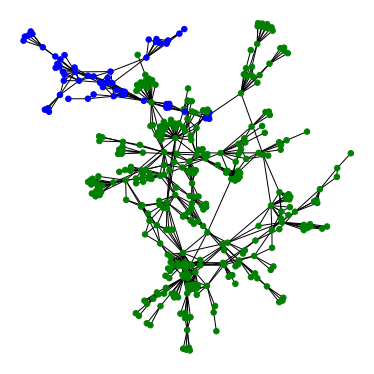

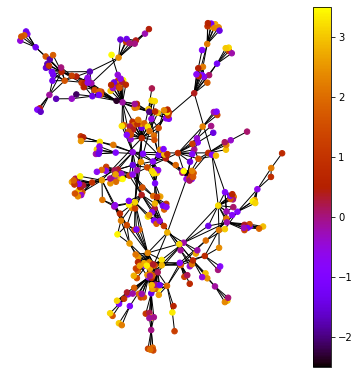

----- iteration 1 ----
objective: 489.049967


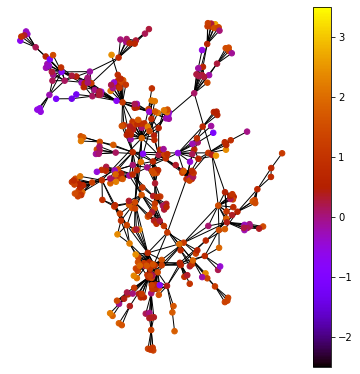

[-0.807 -0.350 -0.206 -0.042 -0.020 0.031 0.155 0.250 0.335 0.355]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 2 ----
objective: 253.457347


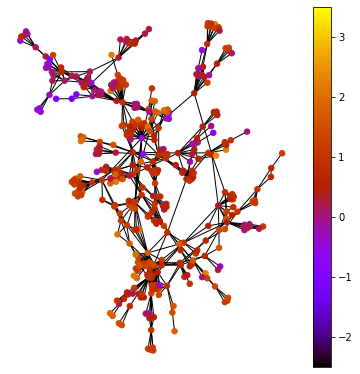

[-0.713 -0.190 -0.161 -0.025 0.020 0.082 0.230 0.368 0.408 0.455]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 3 ----
objective: 112.383333


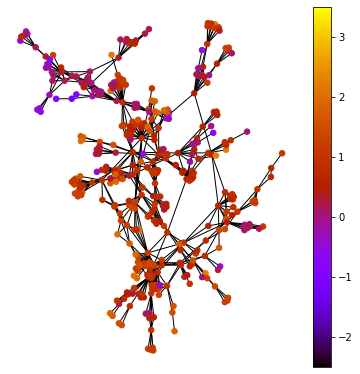

[-0.691 -0.154 -0.149 -0.014 0.041 0.094 0.252 0.392 0.442 0.459]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 4 ----
objective: 83.324003


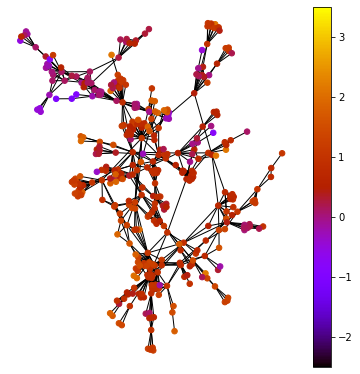

[-0.654 -0.131 -0.094 -0.004 0.070 0.116 0.279 0.433 0.465 0.471]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 5 ----
objective: 48.982178


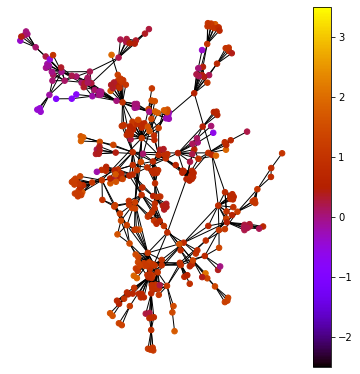

[-0.548 -0.081 0.019 0.075 0.140 0.185 0.339 0.484 0.493 0.545]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 6 ----
objective: 38.829154


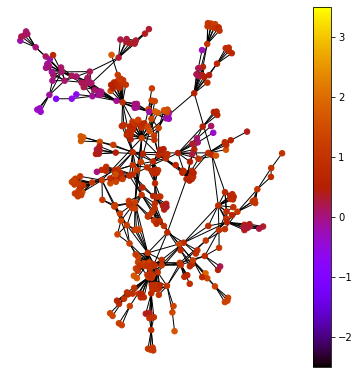

[-0.405 -0.028 0.055 0.204 0.276 0.285 0.380 0.502 0.512 0.585]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 7 ----
objective: 23.127887


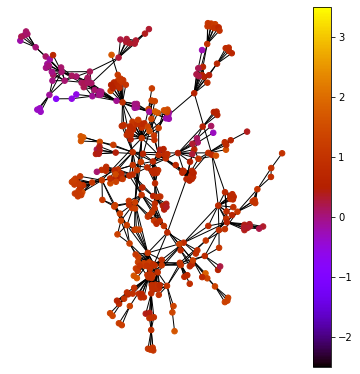

[-0.380 -0.021 0.059 0.210 0.303 0.303 0.384 0.510 0.516 0.588]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 8 ----
objective: 17.329081


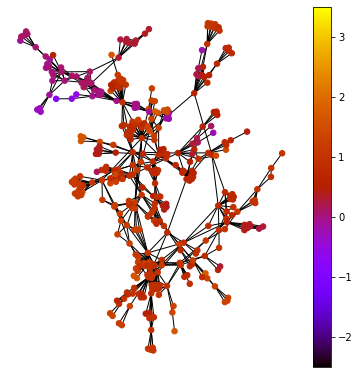

[-0.329 -0.007 0.071 0.222 0.341 0.356 0.390 0.520 0.521 0.599]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 9 ----
objective: 12.880194


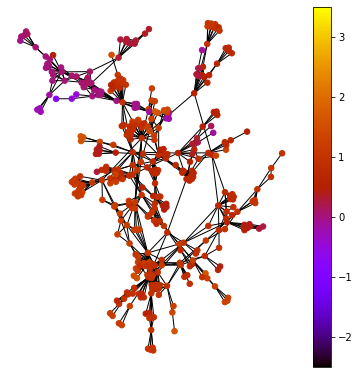

[-0.252 0.011 0.091 0.239 0.396 0.400 0.431 0.526 0.533 0.617]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 10 ----
objective: 7.312546


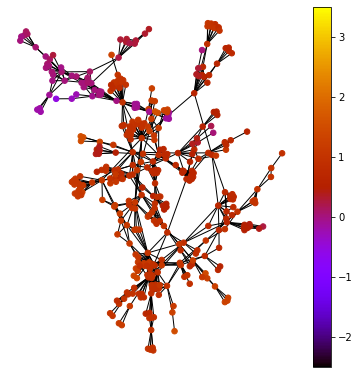

[-0.119 0.048 0.124 0.263 0.400 0.507 0.531 0.545 0.558 0.656]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 11 ----
objective: 4.210013


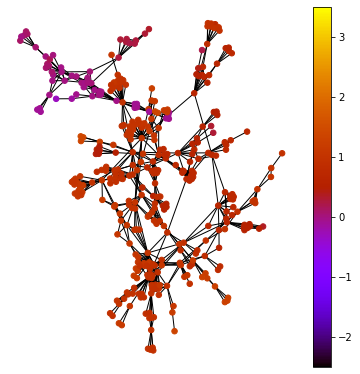

[-0.017 0.150 0.171 0.291 0.399 0.537 0.598 0.645 0.648 0.715]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 12 ----
objective: 3.021265


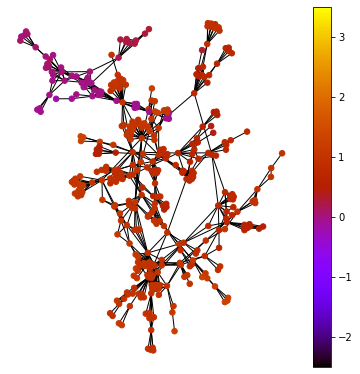

[-0.001 0.168 0.239 0.302 0.395 0.543 0.622 0.675 0.700 0.746]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 13 ----
objective: 2.310060


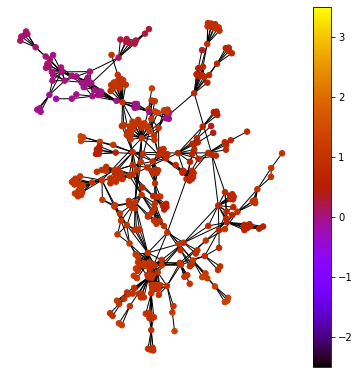

[-0.001 0.167 0.235 0.300 0.392 0.543 0.625 0.679 0.704 0.749]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 14 ----
objective: 1.996927


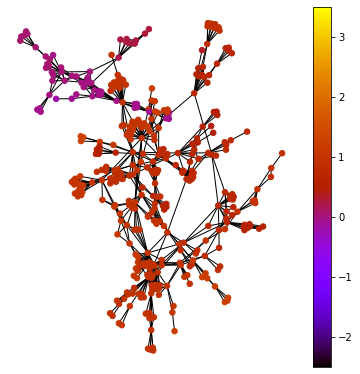

[0.000 0.167 0.241 0.300 0.388 0.544 0.632 0.686 0.713 0.756]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 15 ----
objective: 1.634127


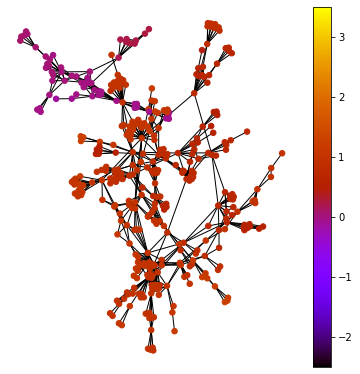

[0.006 0.170 0.267 0.307 0.379 0.549 0.652 0.704 0.735 0.755]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 16 ----
objective: 1.393338


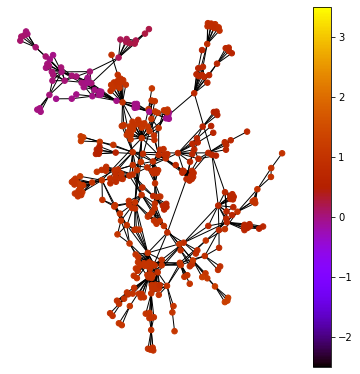

[0.013 0.174 0.288 0.333 0.364 0.562 0.684 0.729 0.755 0.760]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 17 ----
objective: 1.158263


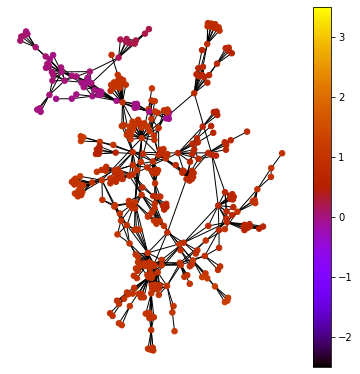

[0.014 0.175 0.288 0.338 0.360 0.565 0.692 0.735 0.756 0.765]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 18 ----
objective: 1.006673


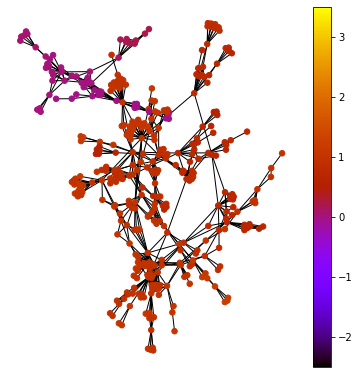

[0.015 0.175 0.288 0.344 0.354 0.568 0.703 0.744 0.759 0.772]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 19 ----
objective: 0.866093


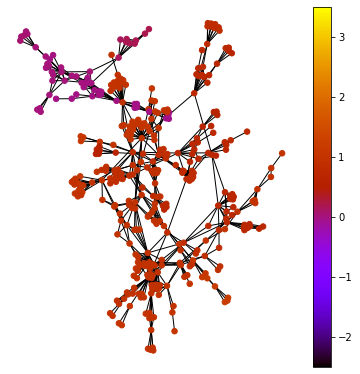

[0.017 0.174 0.285 0.345 0.354 0.574 0.721 0.757 0.764 0.781]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 20 ----
objective: 0.741611


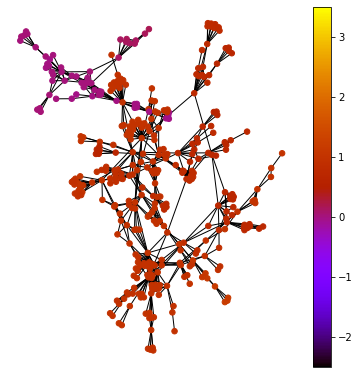

[0.020 0.171 0.270 0.325 0.372 0.586 0.766 0.777 0.788 0.799]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 21 ----
objective: 0.587876


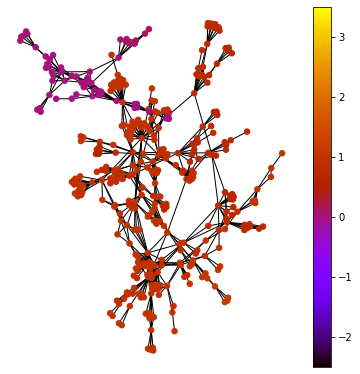

[0.021 0.171 0.268 0.323 0.376 0.588 0.772 0.778 0.791 0.802]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 22 ----
objective: 0.529461


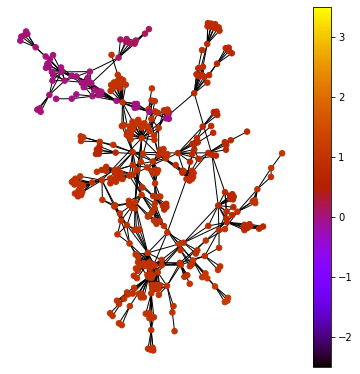

[0.021 0.171 0.265 0.321 0.377 0.588 0.777 0.779 0.794 0.804]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 23 ----
objective: 0.464144


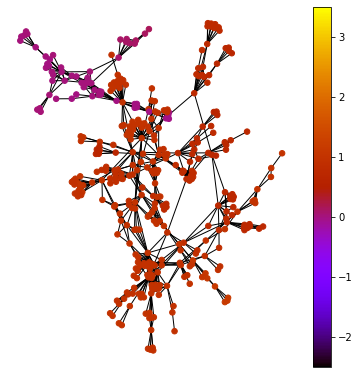

[0.022 0.170 0.258 0.317 0.380 0.589 0.781 0.789 0.802 0.809]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 24 ----
objective: 0.345263


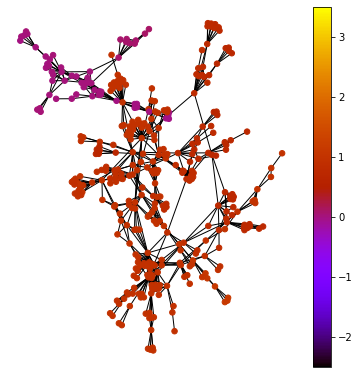

[0.022 0.167 0.240 0.309 0.384 0.590 0.786 0.814 0.822 0.823]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 25 ----
objective: 0.292743


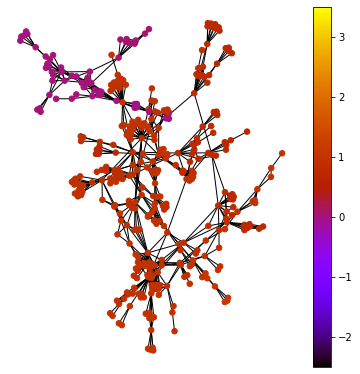

[0.022 0.165 0.224 0.304 0.386 0.590 0.790 0.822 0.836 0.846]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 26 ----
objective: 0.229668


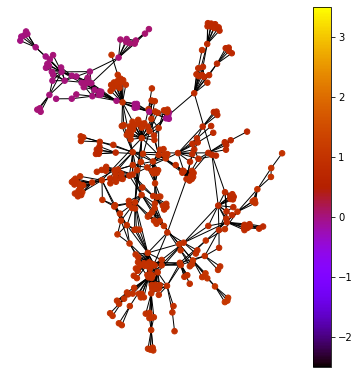

[0.021 0.163 0.210 0.300 0.387 0.589 0.791 0.827 0.846 0.865]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 27 ----
objective: 0.191600


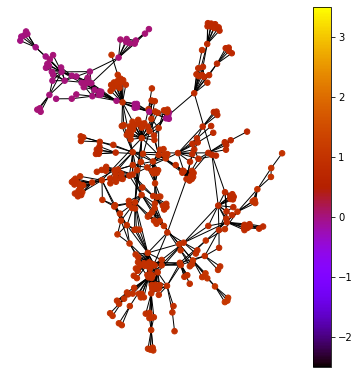

[0.021 0.162 0.203 0.298 0.386 0.587 0.791 0.831 0.853 0.876]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 28 ----
objective: 0.152612


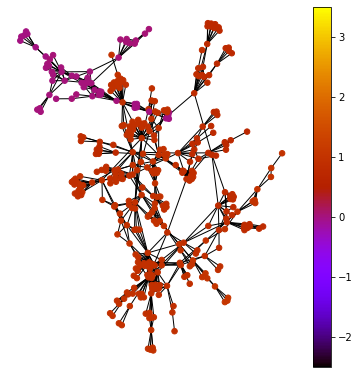

[0.020 0.161 0.195 0.296 0.384 0.584 0.790 0.835 0.862 0.888]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 29 ----
objective: 0.121853


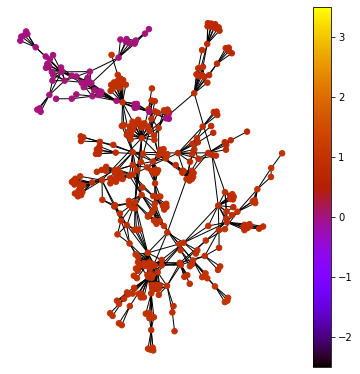

[0.018 0.158 0.184 0.293 0.383 0.580 0.788 0.841 0.876 0.906]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 30 ----
objective: 0.099138


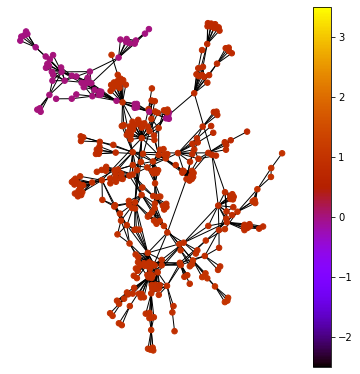

[0.016 0.155 0.179 0.291 0.382 0.577 0.787 0.846 0.886 0.917]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 31 ----
objective: 0.087015


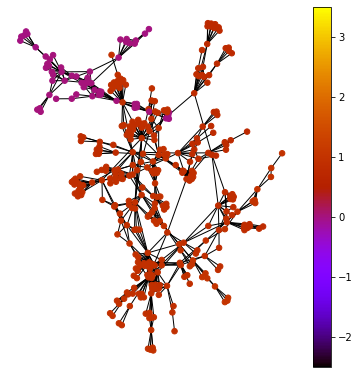

[0.016 0.156 0.180 0.292 0.383 0.578 0.787 0.847 0.886 0.916]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 32 ----
objective: 0.076574


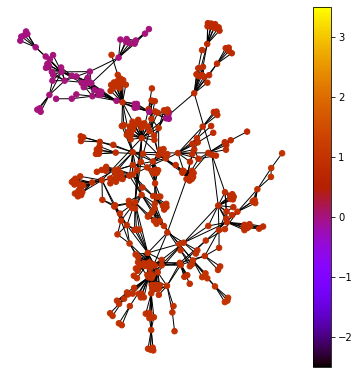

[0.016 0.156 0.180 0.292 0.384 0.578 0.787 0.848 0.889 0.918]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 33 ----
objective: 0.065660


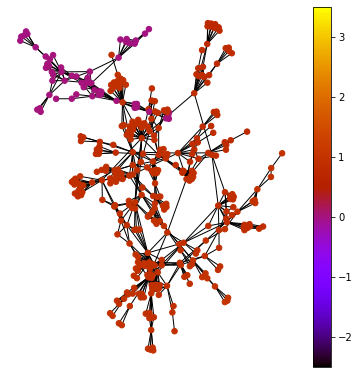

[0.014 0.155 0.179 0.293 0.384 0.577 0.786 0.853 0.896 0.924]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 34 ----
objective: 0.054725


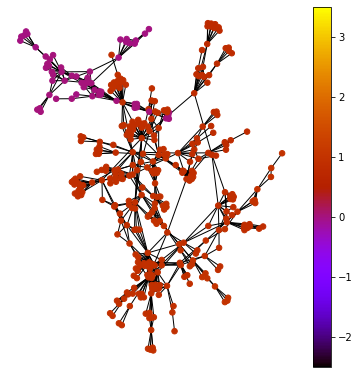

[0.013 0.153 0.178 0.293 0.383 0.576 0.785 0.857 0.902 0.930]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 35 ----
objective: 0.048116


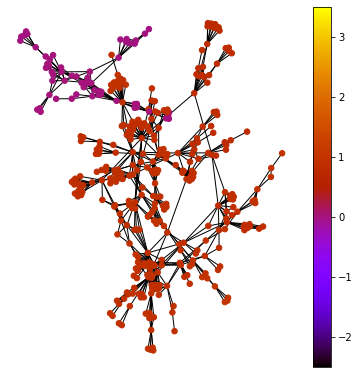

[0.012 0.151 0.178 0.292 0.382 0.575 0.784 0.860 0.905 0.933]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 36 ----
objective: 0.042189


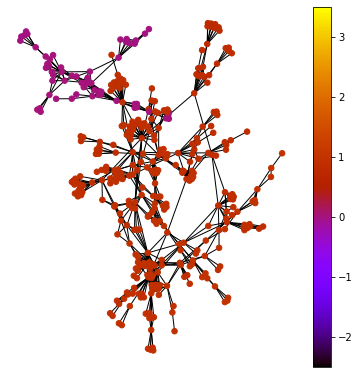

[0.011 0.150 0.178 0.292 0.381 0.574 0.783 0.862 0.908 0.936]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 37 ----
objective: 0.033912


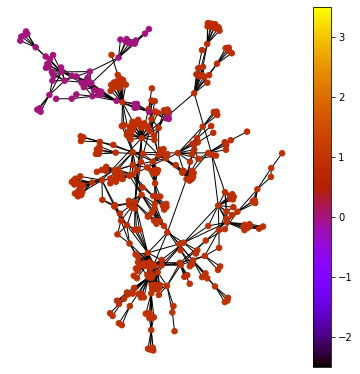

[0.010 0.150 0.178 0.293 0.379 0.573 0.782 0.866 0.911 0.939]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 38 ----
objective: 0.026733


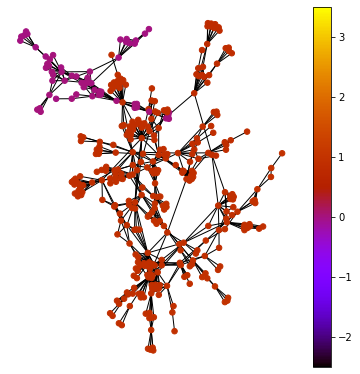

[0.009 0.151 0.179 0.293 0.376 0.572 0.780 0.872 0.914 0.942]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 39 ----
objective: 0.022236


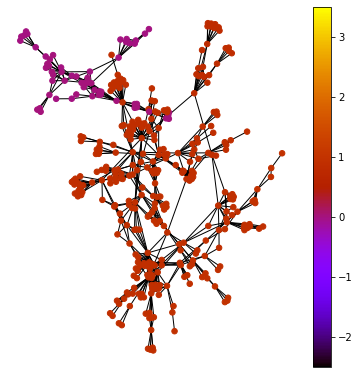

[0.008 0.152 0.179 0.293 0.375 0.571 0.779 0.874 0.915 0.943]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 40 ----
objective: 0.019454


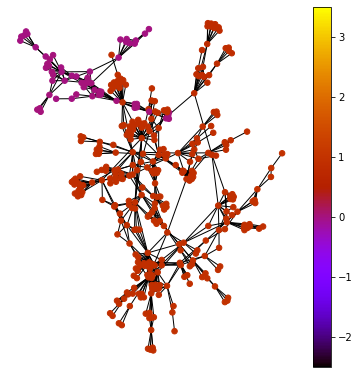

[0.008 0.152 0.179 0.293 0.374 0.571 0.779 0.876 0.915 0.943]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 41 ----
objective: 0.017089


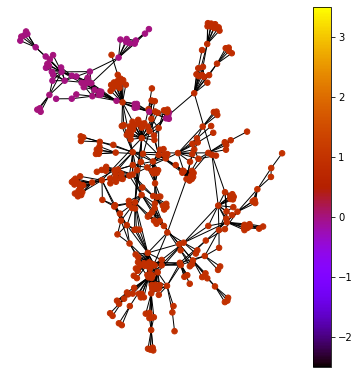

[0.008 0.152 0.179 0.292 0.374 0.570 0.778 0.877 0.916 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 42 ----
objective: 0.014424


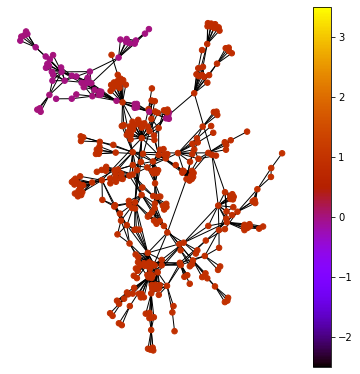

[0.007 0.152 0.178 0.291 0.373 0.568 0.776 0.880 0.917 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 43 ----
objective: 0.012543


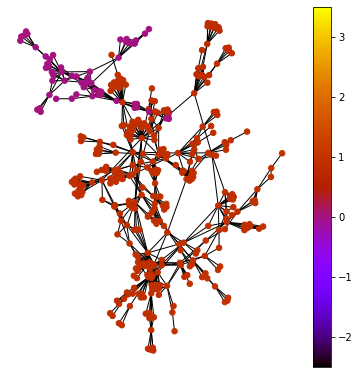

[0.006 0.152 0.177 0.290 0.372 0.567 0.775 0.884 0.918 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 44 ----
objective: 0.011093


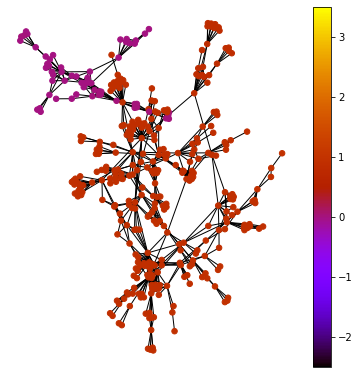

[0.006 0.152 0.177 0.290 0.371 0.566 0.774 0.885 0.918 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 45 ----
objective: 0.009799


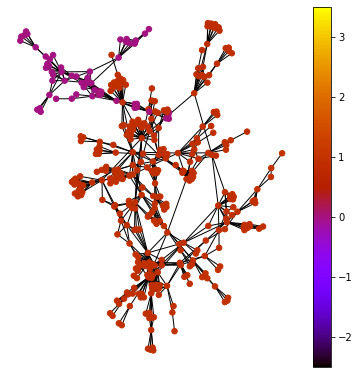

[0.006 0.153 0.177 0.289 0.371 0.566 0.774 0.886 0.918 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 46 ----
objective: 0.008863


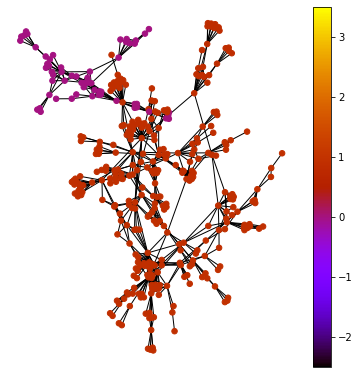

[0.005 0.154 0.176 0.288 0.371 0.565 0.773 0.888 0.919 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 47 ----
objective: 0.007670


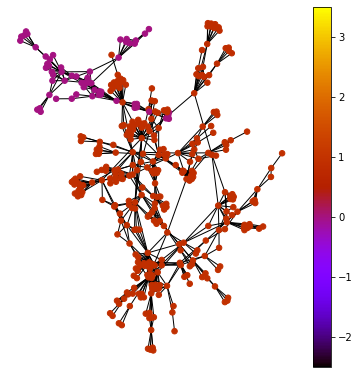

[0.005 0.154 0.175 0.287 0.371 0.564 0.772 0.889 0.919 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 48 ----
objective: 0.007011


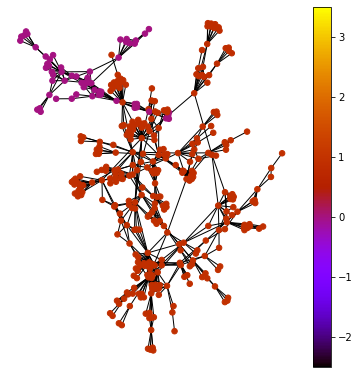

[0.005 0.155 0.175 0.287 0.371 0.564 0.772 0.890 0.920 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 49 ----
objective: 0.006093


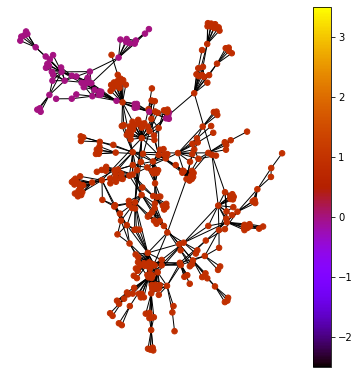

[0.004 0.155 0.174 0.286 0.371 0.563 0.771 0.892 0.920 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 50 ----
objective: 0.005037


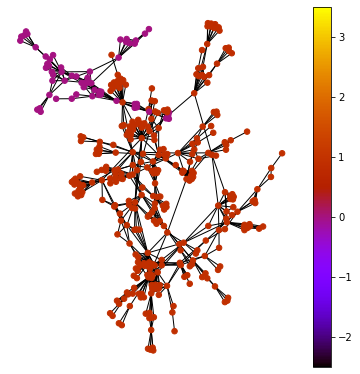

[0.004 0.155 0.174 0.285 0.370 0.563 0.771 0.894 0.921 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 51 ----
objective: 0.004832


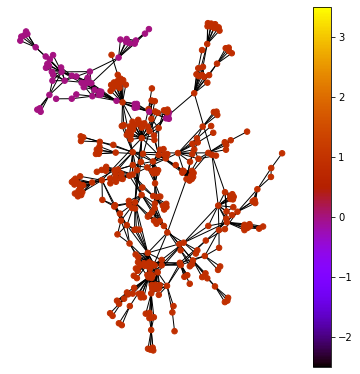

[0.003 0.155 0.173 0.283 0.370 0.562 0.770 0.897 0.923 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 52 ----
objective: 0.003963


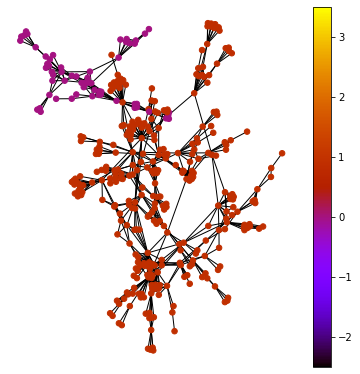

[0.003 0.155 0.173 0.284 0.370 0.562 0.770 0.896 0.922 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 53 ----
objective: 0.003730


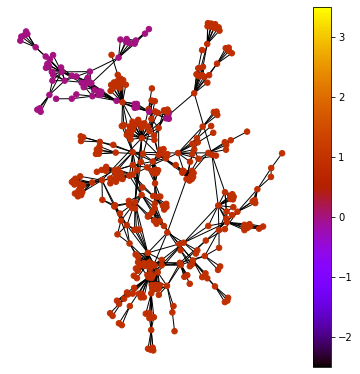

[0.003 0.155 0.173 0.284 0.370 0.562 0.770 0.897 0.922 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 54 ----
objective: 0.003247


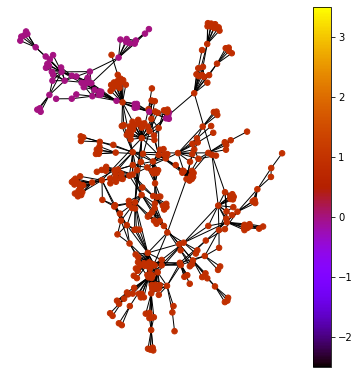

[0.003 0.155 0.173 0.284 0.369 0.562 0.770 0.898 0.923 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 55 ----
objective: 0.002992


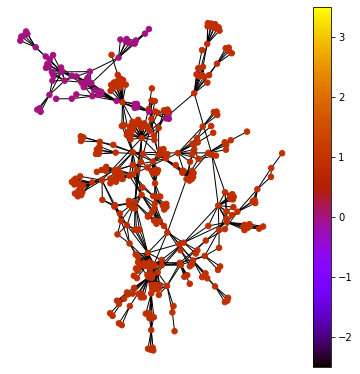

[0.002 0.155 0.172 0.283 0.369 0.562 0.770 0.898 0.924 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 56 ----
objective: 0.002689


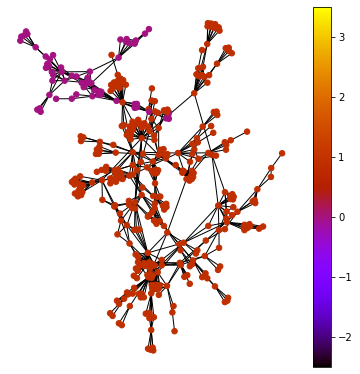

[0.002 0.155 0.172 0.283 0.368 0.561 0.769 0.899 0.925 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 57 ----
objective: 0.002389


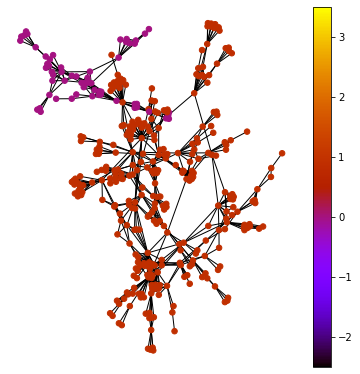

[0.002 0.154 0.172 0.282 0.368 0.561 0.769 0.900 0.926 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 58 ----
objective: 0.002065


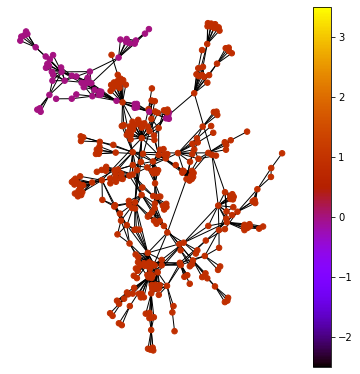

[0.001 0.154 0.171 0.282 0.368 0.561 0.768 0.901 0.927 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 59 ----
objective: 0.001982


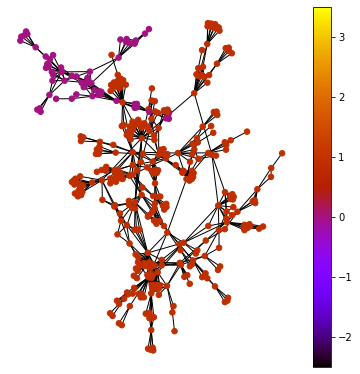

[0.001 0.153 0.171 0.281 0.367 0.560 0.767 0.903 0.929 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 60 ----
objective: 0.001574


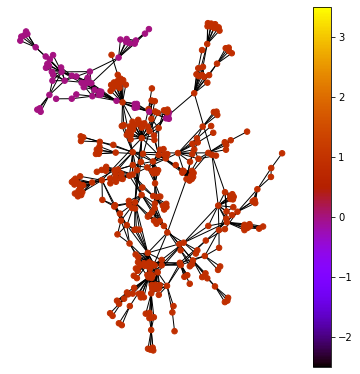

[0.000 0.153 0.171 0.281 0.367 0.560 0.767 0.903 0.929 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 61 ----
objective: 0.001443


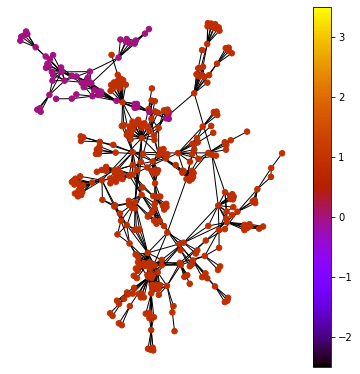

[0.001 0.153 0.171 0.281 0.367 0.561 0.767 0.903 0.929 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 62 ----
objective: 0.001271


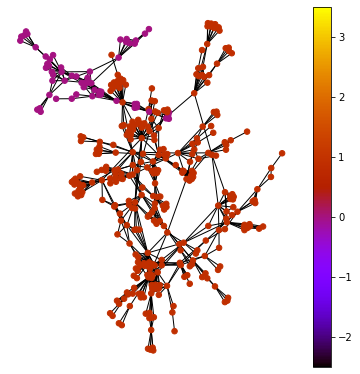

[0.000 0.153 0.171 0.281 0.367 0.561 0.767 0.903 0.929 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 63 ----
objective: 0.001063


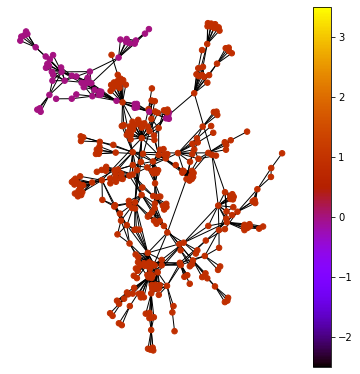

[0.000 0.153 0.171 0.281 0.367 0.561 0.767 0.903 0.930 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 64 ----
objective: 0.000942


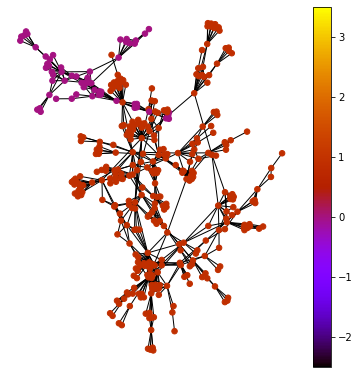

[-0.000 0.152 0.170 0.281 0.367 0.561 0.767 0.904 0.931 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 65 ----
objective: 0.000822


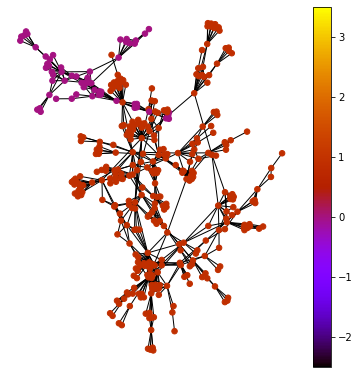

[-0.000 0.152 0.170 0.281 0.366 0.561 0.767 0.904 0.932 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 66 ----
objective: 0.000762


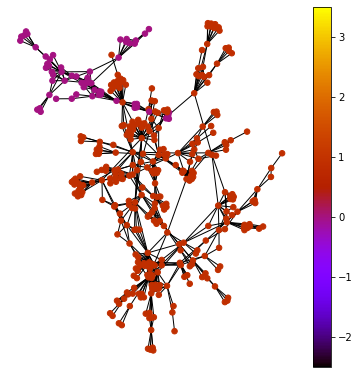

[-0.000 0.152 0.170 0.281 0.366 0.560 0.766 0.904 0.932 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 67 ----
objective: 0.000685


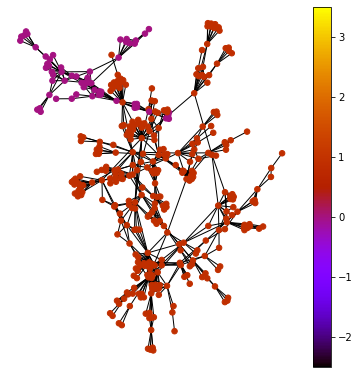

[-0.001 0.152 0.170 0.281 0.366 0.560 0.766 0.904 0.932 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 68 ----
objective: 0.000618


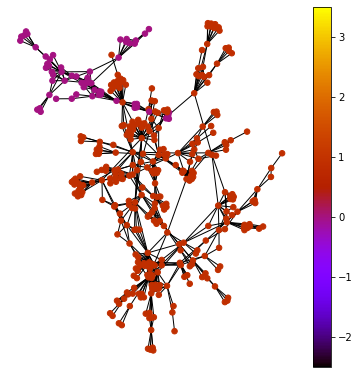

[-0.001 0.152 0.170 0.280 0.366 0.560 0.766 0.904 0.933 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 69 ----
objective: 0.000564


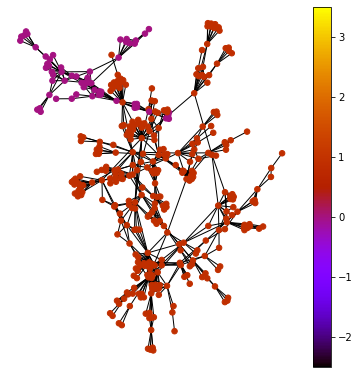

[-0.001 0.152 0.170 0.280 0.366 0.560 0.766 0.904 0.933 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 70 ----
objective: 0.000518


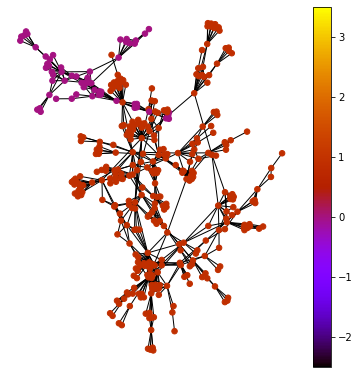

[-0.001 0.152 0.170 0.281 0.366 0.560 0.766 0.905 0.933 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 71 ----
objective: 0.000474


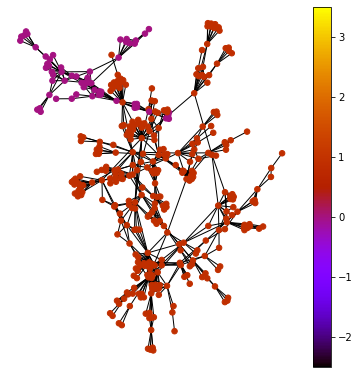

[-0.001 0.152 0.170 0.281 0.366 0.560 0.766 0.905 0.933 0.944]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 72 ----
objective: 0.000426


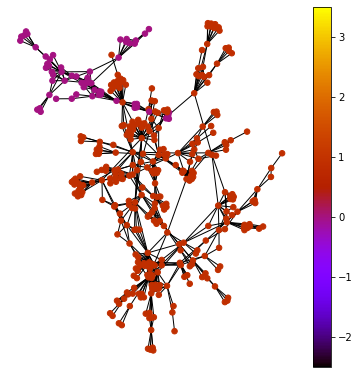

[-0.001 0.151 0.170 0.281 0.366 0.560 0.766 0.905 0.933 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 73 ----
objective: 0.000362


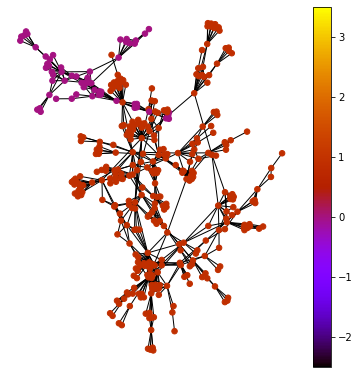

[-0.001 0.151 0.170 0.281 0.366 0.559 0.766 0.905 0.933 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 74 ----
objective: 0.000338


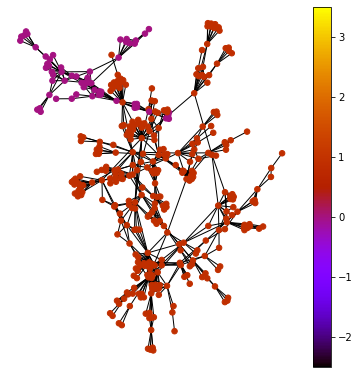

[-0.001 0.151 0.170 0.280 0.366 0.559 0.766 0.905 0.934 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 75 ----
objective: 0.000293


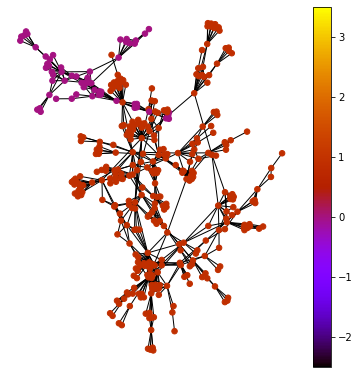

[-0.001 0.151 0.170 0.280 0.366 0.559 0.766 0.905 0.934 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 76 ----
objective: 0.000256


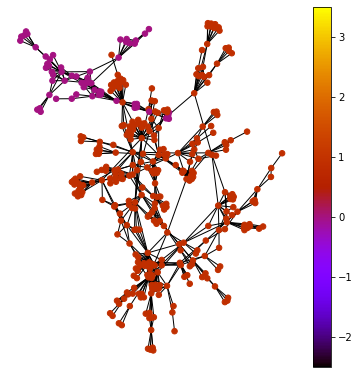

[-0.001 0.151 0.170 0.280 0.366 0.559 0.766 0.905 0.934 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 77 ----
objective: 0.000225


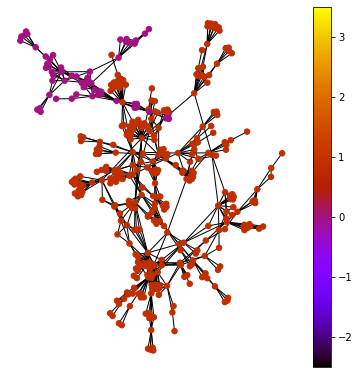

[-0.001 0.151 0.170 0.280 0.367 0.559 0.766 0.905 0.934 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 78 ----
objective: 0.000202


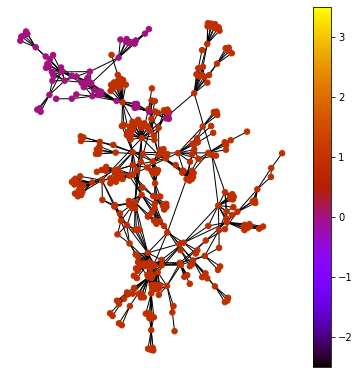

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 79 ----
objective: 0.000184


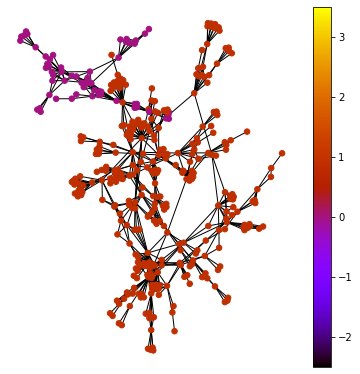

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 80 ----
objective: 0.000170


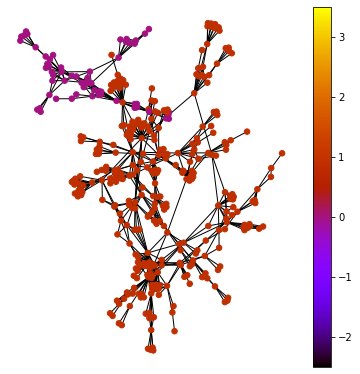

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.945]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 81 ----
objective: 0.000144


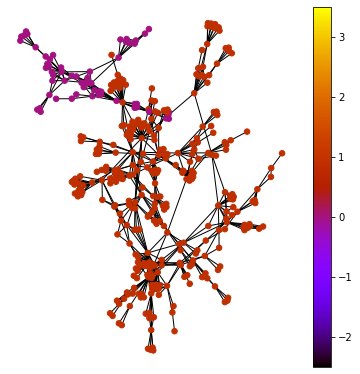

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 82 ----
objective: 0.000125


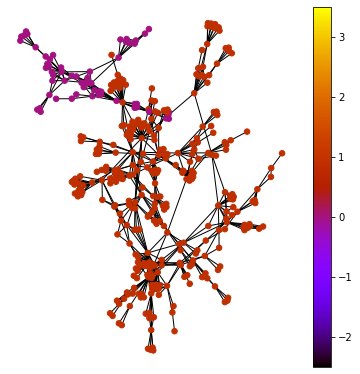

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 83 ----
objective: 0.000117


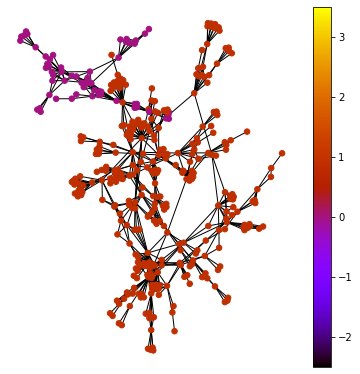

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 84 ----
objective: 0.000095


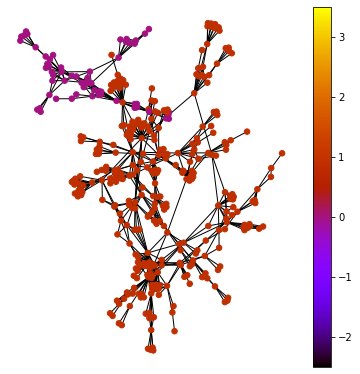

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 85 ----
objective: 0.000087


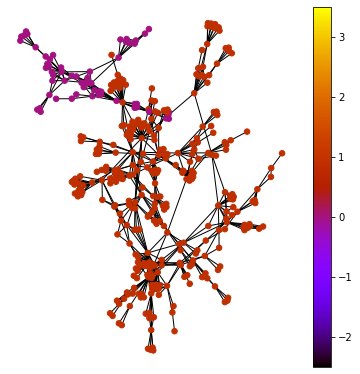

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 86 ----
objective: 0.000080


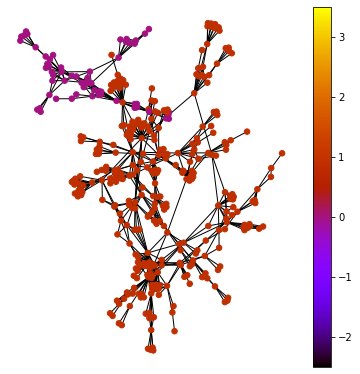

[-0.001 0.151 0.170 0.281 0.367 0.559 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 87 ----
objective: 0.000064


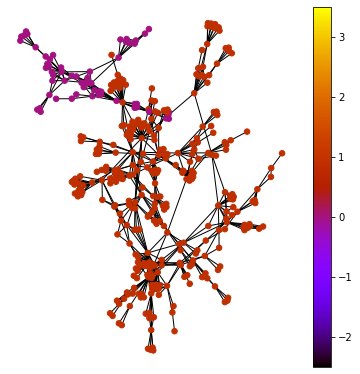

[-0.000 0.151 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 88 ----
objective: 0.000055


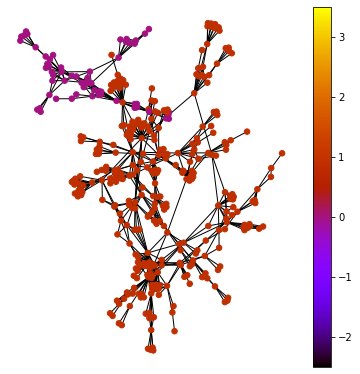

[-0.000 0.151 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 89 ----
objective: 0.000047


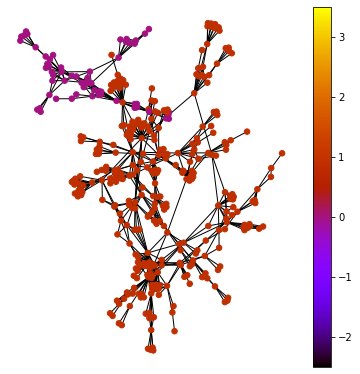

[-0.000 0.151 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.946]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 90 ----
objective: 0.000039


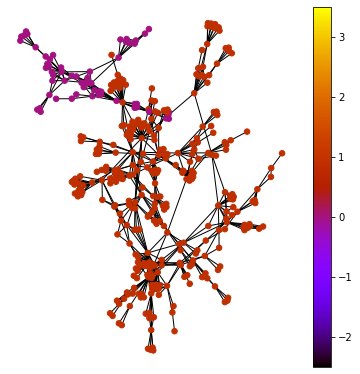

[-0.000 0.151 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 91 ----
objective: 0.000033


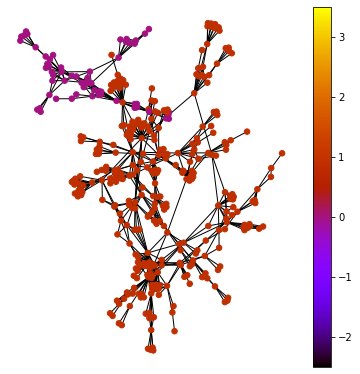

[-0.000 0.151 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 92 ----
objective: 0.000028


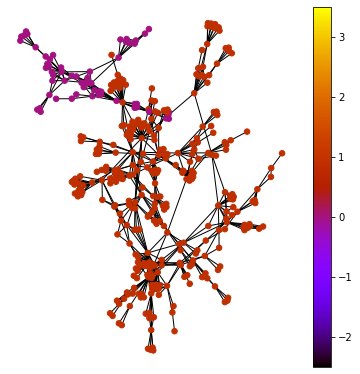

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 93 ----
objective: 0.000024


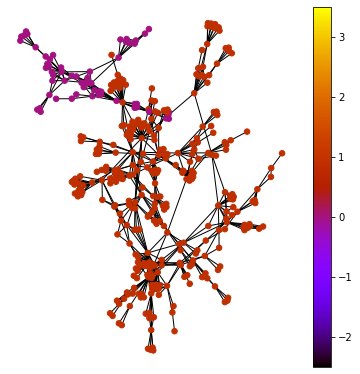

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 94 ----
objective: 0.000021


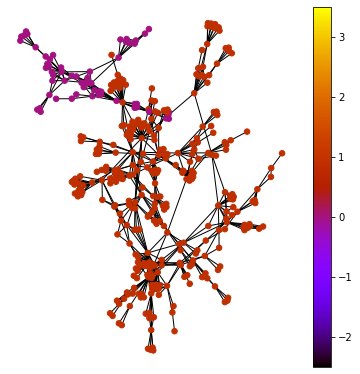

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 95 ----
objective: 0.000019


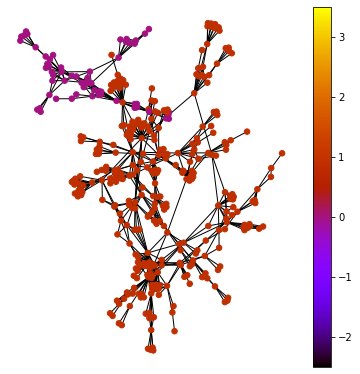

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 96 ----
objective: 0.000018


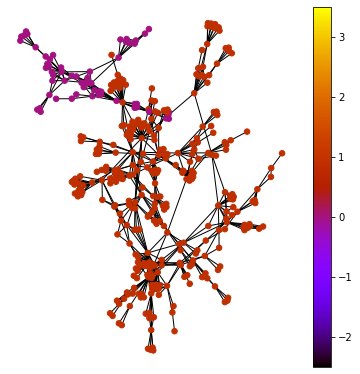

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 97 ----
objective: 0.000015


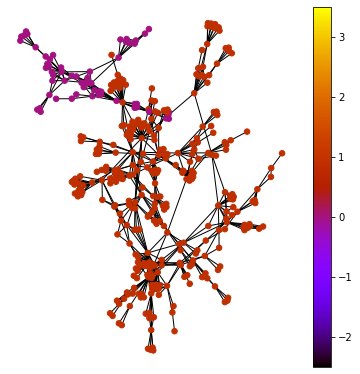

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 98 ----
objective: 0.000014


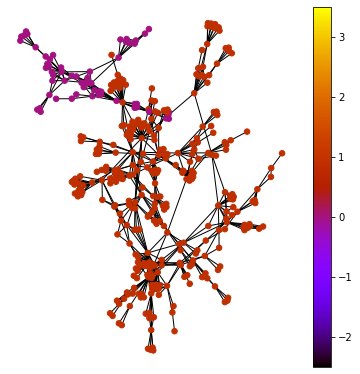

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 99 ----
objective: 0.000013


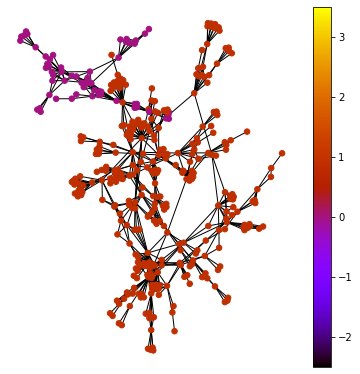

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]


----- iteration 100 ----
objective: 0.000012


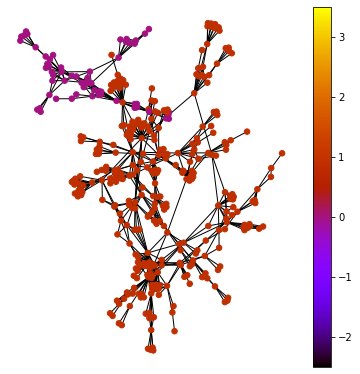

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]




      fun: DeviceArray(0.000, dtype=float64)
 hess_inv: <143641x143641 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.000, 0.000, 0.000, ..., 0.000, -0.000, -0.000])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 107
      nit: 100
     njev: 107
   status: 0
  success: True
        x: array([0.905, 0.000, 0.000, ..., 0.000, 0.000, -0.000])


objective: 0.000012 

[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 0.905 0.934 0.947]
[-0.000 0.152 0.170 0.281 0.367 0.560 0.767 1.000 1.031 1.186]




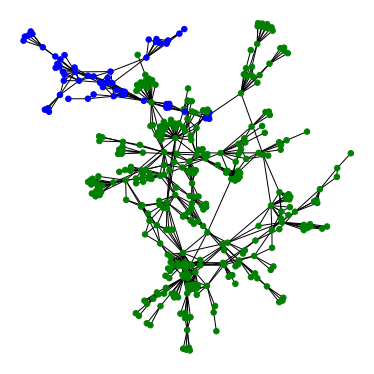

In [39]:
from scipy.optimize import minimize
import jax.numpy as nnp
from jax import grad
import random

Nfeval = 1
evnr = 5


    
plt.rcParams["figure.figsize"] = (5,5)
vmin=-noise/2
vmax=rest+noise/2

    
    
    


mask=oh.create_diag_support_full(full_size,size_part,well)
    

pos = nx.spring_layout(G)
nx.draw(G, node_color=color_map,pos=pos,node_size=30)#, with_labels=True)
plt.show()

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

D=nnp.diag(nnp.asarray(D_part))
L_full=nnp.asarray(L_full)
D_part=nnp.asarray(D_part)




G=nx.from_numpy_matrix(A)



cmap=plt.cm.gnuplot
nx.draw(G, node_color=diag_init,vmin=vmin,vmax=vmax,cmap=cmap,node_size=30,pos=pos)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.show()


maski=nnp.ndarray.flatten(mask)


    
    

bnds=oh.bounds_anything(mask, full_size,maski)  

        


con={'type':'eq', 'fun':constraints}#,'args':(L_full,ones,)}
cons=[con] 
              
grad_obj=grad(objective)   
a=grad_obj(x0,D_part,L_full,5,mu).transpose()


#fig=plt.imshow(nnp.reshape(a,(full_size,full_size)))
plt.show()

#for i in range(5,6):
evnr=5
sol=minimize(objective,x0,args=(D_part,L_full,evnr,mu),method='L-BFGS-B',jac=gradgrad,bounds=bnds,callback=callbackF,options={'ftol':1e-06,'gtol':1e-06})#,constraints=cons)#,options={'maxiter':10}) 
print('\n')
print(sol)
print('\n')
res=nnp.reshape(sol.x,(full_size,full_size))
x0=sol.x
Nfeval=0
    
print("objective: %f \n" %(sol.fun))
ham = L_full +res
D_ham,U_ham=nnp.linalg.eigh(ham)

print((D_ham[0:10]))
print(D_part[0:10])
print("\n")




nx.draw(G, node_color=color_map,pos=pos,node_size=30)#, with_labels=True)
plt.show()